In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from tqdm import tqdm
from datetime import datetime
from sklearn.utils import shuffle
import dlib
from imutils import face_utils

%load_ext tensorboard

2023-04-25 21:07:07.299219: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
base_dir = "result"

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join(base_dir, 'logs/func/%s' % stamp)
writer = tf.summary.create_file_writer(logdir)

scalar_logdir = os.path.join(base_dir, 'logs/scalars/%s' % stamp)
file_writer = tf.summary.create_file_writer(scalar_logdir + "/metrics")

checkpoint_path = os.path.join(base_dir, 'logs/model/siamese')

2023-04-25 21:07:19.169243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
K = tf.keras.backend

def preprocess_input(x, data_format = None, version=1):
    x_temp = np.copy(x)
    if data_format is None:
        data_format = K.image_data_format()
    assert data_format in {'channels_last', 'channels_first'}
    
    if version==1:
        if data_format == 'channels_first':
            x_temp = x_temp[:, ::-1, ...]
            x_temp[:, 0, :, :] -= 93.5940
            x_temp[:, 1, :, :] -= 104.7642
            x_temp[:, 2, :, :] -= 129.1863
        else:
            x_temp = x_temp[..., ::-1]
            x_temp[..., 0] -= 93.5940
            x_temp[..., 1] -= 104.7624
            x_temp[..., 2] -= 129.1863
    elif version == 2:
        if data_format == 'channels_first':
            x_temp = x_temp[:, ::-1, ...]
            x_temp[:, 0, :, :] -= 91.4953
            x_temp[:, 1, :, :] -= 103.8827
            x_temp[:, 2, :, :] -= 131.0912
        else:
            x_temp = x_temp[..., ::-1]
            x_temp[..., 0] -= 91.4953
            x_temp[..., 1] -= 103.8827
            x_temp[..., 2] -= 131.0912
    else:
        raise NotImplementedError

    return x_temp

In [4]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataset_path, batch_size=32, shuffle=True):
        self.dataset = self.create_dataset(dataset_path)
        self.dataset_path = dataset_path
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.num_people = len(list(self.dataset.keys()))
        self.on_epoch_end()
        
    def __getitem__(self, index):
        people = list(self.dataset.keys())[index * self.batch_size: (index + 1) * self.batch_size]
        P = []
        A = []
        N = []
        
        for person in people:
            anchor_index = random.randint(0, len(self.dataset[person])-1)
            anchor_person = self.get_image(person, anchor_index)
            
            positive_index = random.randint(0, len(self.dataset[person])-1)
            while positive_index == anchor_index:
                positive_index = random.randint(0, len(self.dataset[person])-1)
            positive_person = self.get_image(person, positive_index)
            
            negative_index = random.randint(0, self.num_people-1)
            negative_person = list(self.dataset.keys())[negative_index]
            while negative_person == person:
                negative_index = random.randint(0, self.num_people-1)
                negative_person = list(self.dataset.keys())[negative_index]
            
            neg_index = random.randint(0, len(self.dataset[negative_person])-1)
            neg_person = self.get_image(negative_person, neg_index)
            
            P.append(positive_person)
            A.append(anchor_person)
            N.append(neg_person)
            
        A = np.asarray(A)
        P = np.asarray(P)
        N = np.asarray(N)
        
        return [A, P, N]
    
    def __len__(self):
        return self.num_people // self.batch_size
    
    def create_dataset(self, dataset_path):
        with open(os.path.join(dataset_path, "list.txt"), 'r') as f:
            dataset = {}
            image_list = f.read().split()
            for image in image_list:
                folder_name, file_name = image.split('/')
                if folder_name in dataset.keys():
                    dataset[folder_name].append(file_name)
                else:
                    dataset[folder_name] = [file_name]
                    
        return dataset
    
    def on_epoch_end(self):
        if self.shuffle:
            keys = list(self.dataset.keys())
            random.shuffle(keys)
            dataset_ = {}
            for key in keys:
                dataset_[key] = self.dataset[key]
            self.dataset = dataset_
            
    def get_image(self, person, index):
        img = cv2.imread(os.path.join(self.dataset_path, os.path.join('images/' + person, self.dataset[person][index])))
        img = cv2.resize(img, (224, 224))
        img = np.asarray(img, dtype=np.float64)
        img = preprocess_input(img)
        
        return img

In [5]:
embedding = tf.keras.models.Sequential([
    tf.keras.layers.Convolution2D(64, (3, 3), activation='relu', padding="SAME", input_shape=(224, 224, 3)),
    tf.keras.layers.Convolution2D(64, (3, 3), activation='relu', padding="SAME"),
    tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
    
    tf.keras.layers.Convolution2D(128, (3, 3), activation='relu', padding="SAME"),
    tf.keras.layers.Convolution2D(128, (3, 3), activation='relu', padding="SAME"),
    tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
    
    tf.keras.layers.Convolution2D(256, (3, 3), activation='relu', padding="SAME"),
    tf.keras.layers.Convolution2D(256, (3, 3), activation='relu', padding="SAME"),
    tf.keras.layers.Convolution2D(256, (3, 3), activation='relu', padding="SAME"),
    tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
    
    tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding="SAME"),
    tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding="SAME"),
    tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding="SAME"),
    tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
    
    tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding="SAME"),
    tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding="SAME"),
    tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding="SAME"),
    tf.keras.layers.MaxPooling2D((2,2), strides=(2,2),),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2622, activation='softmax')
])

In [6]:
embedding.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [7]:
embedding.load_weights(os.path.join('rcmalli_vggface_tf_vgg16.h5'))

In [8]:
embedding.pop()
embedding.add(tf.keras.layers.Dense(128, use_bias=False))

In [9]:
for layer in embedding.layers[:-2]:
    layer.trainable = False

In [10]:
embedding.layers

In [11]:
class SiameseNetwork(tf.keras.Model):
    def __init__(self, embedding):
        super(SiameseNetwork, self).__init__()
        self.embedding = embedding
        
    @tf.function
    def call(self, inputs):
        anchor_img, pos_img, neg_img = inputs
        with tf.name_scope("Anchor") as scope:
            feature_1 = self.embedding(anchor_img)
            feature_1 = tf.math.l2_normalize(feature_1, axis=-1)
        with tf.name_scope("Positive") as scope:
            feature_2 = self.embedding(pos_img)
            feature_2 = tf.math.l2_normalize(feature_2, axis=-1)
        with tf.name_scope("Negative") as scope:
            feature_3 = self.embedding(neg_img)
            feature_3 = tf.math.l2_normalize(feature_3, axis=-1)
        
        return [feature_1, feature_2, feature_3]
    
    @tf.function
    def get_features(self, inputs):
        return tf.math.l2_normalize(self.embedding(inputs), axis=-1)

In [12]:
model = SiameseNetwork(embedding)

In [13]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00006),
              loss = tf.keras.losses.BinaryCrossentropy(),
             metrics = ["accuracy"] )

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00006)

In [14]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [15]:
def loss_fn(x, alpha=0.2):
    
    anchor, positive, negative = x
    positive_dist = tf.keras.backend.sum(tf.keras.backend.square(anchor-positive), axis=-1)
    
    negative_dist = tf.keras.backend.sum(tf.keras.backend.square(anchor-negative), axis=-1)
    
    loss = tf.keras.backend.mean(tf.keras.backend.maximum((positive_dist - negative_dist + alpha), 0.0))
    return loss

In [16]:
def train_step(X):
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = loss_fn(y_pred)
    
    grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    return loss

In [17]:
data_generator = DataGenerator(dataset_path='dataset')

In [18]:
a, p, n = data_generator[0]

In [19]:
checkpoint = tf.train.Checkpoint(model=model)

In [20]:
losses = []
epochs = 16

no_of_batches = data_generator.__len__()

for i in range(1, epochs+1, 1):
    
    loss = 0
    
    with tqdm(total = no_of_batches) as pbar:
        
        description = "Epoch" + str(i) + "/" + str(epochs)
        pbar.set_description_str(description)
        
        for j in range(no_of_batches):
            data = data_generator[j]
            temp = train_step(data)
            loss += temp
            
            pbar.update()
            pbar.set_postfix_str("Loss:" + str(temp.numpy()))
            
        loss /= no_of_batches
        losses.append(loss.numpy())
        
        with file_writer.as_default():
            tf.summary.scalar('Loss', data=loss.numpy(), step=i)
            
        print_statement = "Loss:" + str(loss.numpy())
        pbar.set_postfix_str(print_statement)

checkpoint.save(checkpoint_path)
print("Checkpoint Saved")

Epoch16/16: 100%|█████████████| 15/15 [19:53<00:00, 79.58s/it, Loss:0.024518369]


Checkpoint Saved


In [37]:
model.save("vgg_model")

INFO:tensorflow:Assets written to: vgg_model/assets


INFO:tensorflow:Assets written to: vgg_model/assets


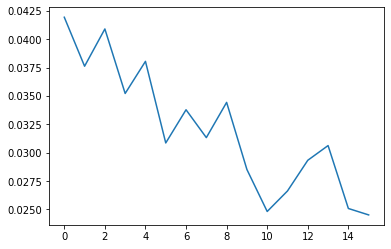

In [21]:
plt.plot(losses)

In [22]:
data_dir = 'data'

In [45]:
name = input("Enter your name: ")
os.mkdir(os.path.join(data_dir, name))

cap = cv2.VideoCapture(0)
img_num = 0

while True:
    ret, frame = cap.read()
    cv2.imshow("Image", frame)
    
    if cv2.waitKey(1) == ord("s"):
        cv2.imwrite(os.path.join(data_dir, name + '/' + str(img_num) + '.jpg'), frame)
        img_num += 1
    if cv2.waitKey(1) == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

Enter your name: codiep


In [23]:
features = []
people = sorted(os.listdir(data_dir))
face_detector = dlib.get_frontal_face_detector()
dumpable_features = {}

In [24]:
for p in people:
    person_path = os.path.join(data_dir, p)
    print(person_path)
    
    images = []
    if os.path.isdir(person_path):
        for img in os.listdir(person_path):
            img_path = os.path.join(person_path, img)
            image = cv2.imread(img_path)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            faces = face_detector(gray, 0)

            if len(faces) == 1:
                for face in faces:
                    face_bbox = face_utils.rect_to_bb(face)
                    if all(i>=0 for i in face_bbox):
                        [x, y, w, h] = face_bbox
                        frame = image[y:y+h, x:x+w]
                        frame = cv2.resize(frame, (224, 224))
                        frame = np.asarray(frame, dtype=np.float64)
                        images.append(frame)
                    
        images = np.asarray(images)
        images = preprocess_input(images)
        images = tf.convert_to_tensor(images)

        feature = model.get_features(images)
        feature = tf.reduce_mean(feature, axis=0)
        features.append(feature.numpy())
        dumpable_features[p] = feature.numpy()

data/.DS_Store
data/codiep
data/hung
data/quanganh


In [25]:
import pickle

In [26]:
with open('weigths.pkl', 'wb') as f:
    pickle.dump(dumpable_features, f) 

In [27]:
with open('weigths.pkl', 'rb') as f:
    dumpable_features_reloaded = pickle.load(f)

people = []
features = []
for key, value in dumpable_features_reloaded.items():
    people.append(key)
    features.append(value)

In [28]:
features = np.asarray(features)

In [ ]:
cap = cv2.VideoCapture(0)
count = 0
name = "not identified"

while True:
    ret, img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    faces = face_detector(gray, 0)
    for face in faces:
        face_bbox = face_utils.rect_to_bb(face)
        if all(i>=0 for i in face_bbox):
            [x, y, w, h] = face_bbox
            frame = img[y:y+h, x:x+w]
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
            frame = cv2.resize(frame, (224, 224))
            frame = np.asarray(frame, dtype=np.float64)
            frame = np.expand_dims(frame, axis=0)
            frame = preprocess_input(frame)
            
            feature = model.get_features(frame)
            
            dist = tf.norm(features - feature, axis=1)
            name = 'not identified'
            loc = tf.argmin(dist)
            
            if dist[loc] < 0.8:
                name = people[loc]
            else:
                pass
            
            font_face = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(img, name, (x, y-5), font_face, 0.8, (0, 255, 0), 3)
    
    cv2.imshow("Image", img)
    if cv2.waitKey(1) == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()

In [84]:
import matplotlib.pyplot as plt

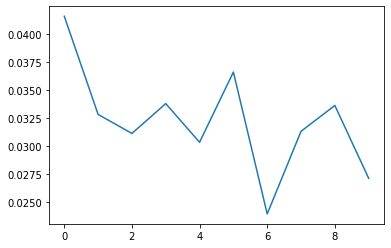

In [87]:
plt.plot(losses)